# QoL Monitor - Feature Selection

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, chi2

# Getting Processed Data

In [2]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [3]:
def getDataset(domain_group):
    return {
        'phy_all': (phy_all, phy_all_pred),
        'psy_all': (psy_all, psy_all_pred),
        
        'phy_init_set': (phy_init_set, phy_init_set_pred),
        'psy_init_set': (psy_init_set, psy_init_set_pred),
        
        'phy_ufpi_ufc': (phy_ufpi_ufc, phy_ufpi_ufc_pred),
        'psy_ufpi_ufc': (psy_ufpi_ufc, psy_ufpi_ufc_pred),
    }[domain_group] 

# Feature Selection

In [4]:
# feature selection
def select_features_regression(X_train, y_train, X_test, stype):
    
    fs = None
    if stype == 'f_regression':
        fs = SelectKBest(score_func=f_regression, k='all')
    elif stype == 'mutual':
        fs = SelectKBest(score_func=mutual_info_regression, k='all')
    elif stype == 'chi':
        fs = SelectKBest(score_func=chi2, k='all')
    # configure to select all features
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def apply_selection(domain_group, stype):
    fs         = None
    X_test_fs  = None
    X_train_fs = None
    
    X, y = getDataset(domain_group)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    X_train_fs, X_test_fs, fs = select_features_regression(X_train, y_train, X_test, stype)
        
    data = []
    for i in range(len(fs.scores_)):
        data.append([X.columns[i], fs.scores_[i]])
        
    df_features = pd.DataFrame(data, columns=['Feature', 'Score'])
    df_features.sort_values(by='Score', ascending=False, inplace=True)
    return df_features, fs

def plot_feature_score(scores):
    pyplot.bar([i for i in range(len(scores.scores_))], scores.scores_)
    pyplot.show()

In [5]:
features_fregression, fs_fregression = apply_selection('phy_all', 'f_regression')
features_mutual, fs_mutual           = apply_selection('phy_all', 'mutual')

In [6]:
features_fregression.head(20)

,Feature,Score
0,height,117.421246
22,mean_nni,93.062909
84,maritalstatus_married,87.083231
85,maritalstatus_single,87.083231
23,sdnn,83.724644
41,children,81.630660
7,awakesleep,77.256678
30,median_nni,73.425541
6,remsleep,64.703089
33,cvnni,61.575670


In [7]:
features_mutual.head(20)

,Feature,Score
1,weight,1.153002
0,height,0.936356
38,specificage,0.866840
40,income,0.469467
3,calories,0.280427
30,median_nni,0.260717
34,mean_hr,0.256413
22,mean_nni,0.242639
23,sdnn,0.217013
45,social,0.202074


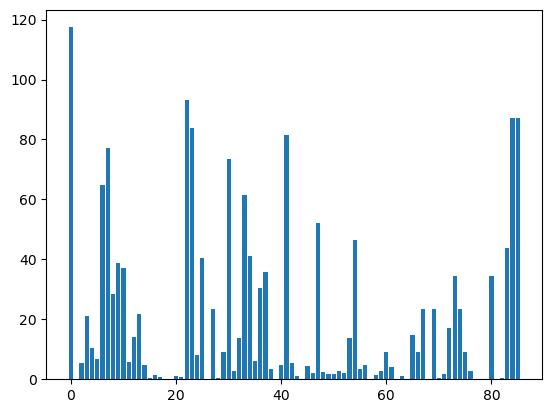

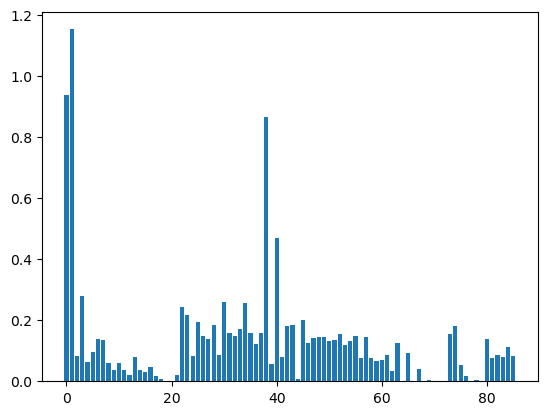

In [8]:
plot_feature_score(fs_fregression)
plot_feature_score(fs_mutual)

# Random Forest with feature selection

In [9]:
def get_baseline_metrics(domain_group):
    return {
        'phy_all': (5.65, 7.98),
        'psy_all': (5.44, 7.52),
    }[domain_group]

In [10]:
def modelingRegressors(domain_group, function, feat_to_select):
    X, y = getDataset(domain_group)
    algorithm = RandomForestRegressor(warm_start=False, n_estimators=1778, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='poisson', bootstrap=False)
    
    skb = SelectKBest(score_func=function, k = feat_to_select)
    
    pipeline = Pipeline([('feat_selection', skb), ('regressor', algorithm)])
    
    kf = KFold(10, shuffle = True, random_state = 42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(pipeline, X.values, y, scoring = "neg_mean_squared_error", cv = kf))
    mae  = -cross_val_score(pipeline, X.values, y, scoring = "neg_mean_absolute_error", cv = kf)
    r2 = cross_val_score(pipeline, X.values, y, scoring = "r2", cv = kf)
    
    b_mae, b_rmse = get_baseline_metrics(domain_group)
    n_mae  = mae.mean() 
    n_rmse = rmse.mean() 
    
    imp_mae  = (n_mae - b_mae) / b_mae
    imp_rmse = (n_rmse - b_rmse) / b_rmse
    
    print('Function:', function, '\tFeatures:', feat_to_select, '\tMAE:', round(mae.mean(), 4), '\tRMSE:',  round(rmse.mean(), 4))
    
    return pd.Series([domain_group, function, feat_to_select,
                      round(mae.mean(), 4),  round(mae.std(), 4), 
                      round(rmse.mean(), 4), round(rmse.std(), 4), 
                      round(r2.mean(), 4),   round(r2.std(), 4),
                     imp_mae, imp_rmse],  index=cols_result_df)

In [11]:
cols_result_df = ['group', 'function', 'k', 'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std', 'r2_mean', 'r2_std', 'i_mae', 'i_rmse']

In [12]:
df_feat_phy = pd.DataFrame(columns = cols_result_df)
for function in [f_regression, mutual_info_regression, chi2]:
    for feat_to_select in range(10, 86, 10):
        result = modelingRegressors('phy_all', function, feat_to_select)
        df_feat_phy = pd.concat([df_feat_phy, result.to_frame().T], ignore_index=True)

Function: <function f_regression at 0x7a6809388160> 	Features: 10 	MAE: 7.0269 	RMSE: 9.3286
Function: <function f_regression at 0x7a6809388160> 	Features: 20 	MAE: 6.4777 	RMSE: 8.7319
Function: <function f_regression at 0x7a6809388160> 	Features: 30 	MAE: 6.395 	RMSE: 8.6793
Function: <function f_regression at 0x7a6809388160> 	Features: 40 	MAE: 6.126 	RMSE: 8.3425
Function: <function f_regression at 0x7a6809388160> 	Features: 50 	MAE: 6.063 	RMSE: 8.2478
Function: <function f_regression at 0x7a6809388160> 	Features: 60 	MAE: 6.042 	RMSE: 8.1625
Function: <function f_regression at 0x7a6809388160> 	Features: 70 	MAE: 5.9237 	RMSE: 8.0461
Function: <function f_regression at 0x7a6809388160> 	Features: 80 	MAE: 5.8139 	RMSE: 7.9223
Function: <function mutual_info_regression at 0x7a680938a9e0> 	Features: 10 	MAE: 5.964 	RMSE: 8.1659
Function: <function mutual_info_regression at 0x7a680938a9e0> 	Features: 20 	MAE: 5.8099 	RMSE: 7.9986
Function: <function mutual_info_regression at 0x7a68093

In [13]:
df_feat_psy = pd.DataFrame(columns = cols_result_df)
for function in [f_regression, mutual_info_regression, chi2]:
    for feat_to_select in range(10, 86, 10):
        result = modelingRegressors('psy_all', function, feat_to_select)
        df_feat_psy = pd.concat([df_feat_psy, result.to_frame().T], ignore_index=True)

Function: <function f_regression at 0x7a6809388160> 	Features: 10 	MAE: 5.942 	RMSE: 8.371
Function: <function f_regression at 0x7a6809388160> 	Features: 20 	MAE: 5.7338 	RMSE: 7.9226
Function: <function f_regression at 0x7a6809388160> 	Features: 30 	MAE: 5.5327 	RMSE: 7.7248
Function: <function f_regression at 0x7a6809388160> 	Features: 40 	MAE: 5.5963 	RMSE: 7.7393
Function: <function f_regression at 0x7a6809388160> 	Features: 50 	MAE: 5.4805 	RMSE: 7.6552
Function: <function f_regression at 0x7a6809388160> 	Features: 60 	MAE: 5.4795 	RMSE: 7.575
Function: <function f_regression at 0x7a6809388160> 	Features: 70 	MAE: 5.4501 	RMSE: 7.5234
Function: <function f_regression at 0x7a6809388160> 	Features: 80 	MAE: 5.4626 	RMSE: 7.5702
Function: <function mutual_info_regression at 0x7a680938a9e0> 	Features: 10 	MAE: 5.5267 	RMSE: 7.7793
Function: <function mutual_info_regression at 0x7a680938a9e0> 	Features: 20 	MAE: 5.3969 	RMSE: 7.4996
Function: <function mutual_info_regression at 0x7a680

In [14]:
df_feat_phy.to_csv('20230714-rforest-feat-sel-physical.csv', index = False)
df_feat_psy.to_csv('20230714-rforest-feat-sel-psychological.csv', index = False)